**READ ME:**

    1. PLEASE READ THE COMMENTS ABOVE EVERY CELL BEFORE EXECUTING/COMPILING THE CODE
    
    2. THIS NOTEBOOK DOES THE FOLLOWING -
    
       SECTION 0: SET UP THE NOTEBOOK
       SECTION 1: CLEAN AND PROCESS THE DATA
       
   **SECTION 2: CREATE FEATURES BASED ON USER SESSIONS i.e. A USER'S MULTIPLE INTERACTIONS IN A GIVEN SESSION**
      
      
       SECTION 3: SPLITTING DATA INTO TRAIN AND TEST
       SECTION 4: FEATURE RANKING
       SECTION 5: DATA TRANSFORMATION
       SECTION 6: BASELINING
       SECTION 7: CREATING SAMPLES - NON STRATIFIED
       SECTION 8: CREATING SAMPLES - STRATIFIED
       SECTION 9: T-SNE
       SECTION 10: CLUSTERING

# 0. ***`SETUP`***

## i. SETTING UP NOTEBOOK

In [ ]:
## This Cell is Only for Usage in a Google CoLab Environment
from google.colab import drive

In [ ]:
## This Cell is Only for Usage in a Google CoLab Environment
ROOT = "/content/drive"
print(ROOT)
drive.mount(ROOT)

In [ ]:
## This Cell is Only for Usage in a Google CoLab Environment
#%pwd
#%cd drive/My Drive/Colab Notebooks/Feature Engineering

## ii. Pre-Processing : Library and Data file import

### Libray Imports

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns #visualisation
import matplotlib.pyplot as plt #visualisation
%matplotlib inline 
sns.set(color_codes=True)
#display all columns in a dataframe
pd.set_option('display.max_columns', 999)
#setting default figure size
plt.rcParams["figure.figsize"] = (8,5)

In [3]:
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
import gc
import time

In [4]:
import imblearn
from imblearn.over_sampling import SMOTE
import collections
from collections import Counter
from sklearn.datasets import make_classification
from matplotlib import pyplot
from numpy import where

In [5]:
from sklearn.utils import shuffle
from sklearn.manifold import TSNE

### Data Imports

Original CSV download

TO DOWNLOAD THE **cosmetics.csv** FILE PLEASE GO TO :

1. https://www.kaggle.com/mkechinov/ecommerce-events-history-in-cosmetics-shop?select=2019-Dec.csv
2. Download the 5 files : 2019-Dec.csv, 2019-Nov.csv, 2019-Oct.csv, 2020-Jan.csv, 2020-Feb.csv
3. Combine the csv files. Combined File size should be 2.27 GB
4. For a quick tutorial on how to combine csv files on MAC please refer: https://serp.co/blog/combine-merge-csv-files-mac/

In [ ]:
## Run this cell for COSMETICS data
shoppers = pd.read_csv("cosmetics.csv")

### Quick File Imports Below 

**Run the cells below if you want to download already processed/compiled data files and skip Sections 1 and 2**

Processed dataframe download

In [8]:
#Run this cell for Cosmetics Data ONLY
df = pd.read_pickle("dfCosmetics.pkl")

Feature Dataset Quick Import

In [6]:
#Run this cell for COSMETICS Data ONLY
FeaturesDF = pd.read_pickle("Cosmetics_Session_Features.pkl")

## iii. CHECK RAM

In [11]:
#AVAILABLE SYSTEM RAM
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

Your runtime has 17.2 gigabytes of available RAM



In [12]:
gc.collect()

40

#    
************************************************
************************************************

# 1. ***`PROCESSING DATA`***
Jump to Section 3 if you have imported FeaturesDF files

In [11]:
#Run this cell for COSMETICS Data ONLY
df = shoppers.copy()

In [ ]:
# Run this cell for COSMETICS data ONLY

df.drop('category_code',axis=1,inplace=True)
df.drop('brand',axis=1,inplace=True)

In [ ]:
#Dropping rows which have headers in them
headerIndices = df[df['event_time']=='event_time'].index
df.drop(headerIndices,inplace=True)

**Formatting Date Time Column**

In [ ]:
df['event_time'] = pd.to_datetime(df['event_time'],format = '%Y-%m-%d %H:%M:%S %Z')

In [ ]:
#Year
df['year'] = (df['event_time']).dt.year

In [ ]:
#Month
df['month'] = (df['event_time']).dt.month
MM = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
df['month'] = df['month'].map(MM)

In [ ]:
# Phase of day
df['hour'] = (df['event_time']).dt.hour
timeOfDay={0:'Dawn',1:'Dawn',2:'Dawn',3:'Dawn',4:'Dawn',5:'EarlyMorning',6:'EarlyMorning',7:'EarlyMorning',8:'EarlyMorning', 9:'Morning',10:'Morning',11:'Morning', 12:'Noon', 13:'Afternoon',14:'Afternoon',15:'Afternoon',16:'Afternoon', 17:'Evening',18:'Evening',19:'Evening',20:'Evening', 21:'Night',22:'Night',23:'Night', 24:'Midnight'}
df['timeOfDay'] = df['hour'].map(timeOfDay)

In [ ]:
# Weekday
dayOfWeek={0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fr', 5:'Sat', 6:'Sun'}
df['weekday'] = (df['event_time']).dt.weekday.map(dayOfWeek)

In [ ]:
# Is Weekend?
df['Weekend']= df.weekday.apply(lambda x : 1 if x in ['Sunday','Saturday'] else 0)

**Formatting Other Column Types**

In [ ]:
df['price']= pd.to_numeric(df['price'])

In [ ]:
#DROPPING ROWS WHICH HAVE NEGATIVE VALUE OF PRICE
negative_price = df[df['price']<0]
negative_price = negative_price.index
df = df.drop(negative_price)

In [ ]:
df['year']= pd.to_numeric(df['year'])
df['hour']= pd.to_numeric(df['hour'])
df['Weekend']= pd.to_numeric(df['Weekend'])

In [ ]:
df['event_type'] = df['event_type'].astype(str)
df['product_id'] = df['product_id'].astype(str)
df['category_id'] = df['category_id'].astype(str)
df['product_id'] = df['product_id'].astype(str)
df['user_id'] = df['user_id'].astype(str)
df['user_session'] = df['user_session'].astype(str)
df['month'] = df['month'].astype(str)
df['weekday'] = df['weekday'].astype(str)
df['timeOfDay'] = df['timeOfDay'].astype(str)

In [ ]:
#Dropping Rows where the user_session is NAN

Null_Sessions = df[df['user_session']=='nan'].index
Null_Sessions
df = df.drop(Null_Sessions)

**SAVE TO PICKLE**

In [ ]:
## Run this cell only for COSMETICS Data ONLY to Save and Load Pickle Files

#df.to_pickle("dfCosmetics.pkl")

In [ ]:
df.shape

#    
************************************************
************************************************

# 2. **`CREATING SESSION BASED FEATURES`**

## Features to build:

    Weekday(Sun/Mon/...) [One hot encoded]
    Month [One hot encoded]
    TimeOfDay(Morning/Evening/....) [One hot encoded]
    Weekend
    InteractionTime(Duration of Session in seconds)
    
    NumTotalEventsInSession()
    NumViewEventsInSession
    NumCartEventsInSession
    NumRemoveEventsInSession --- Only for Cosmetics Data
    
    NumCategoriesViewedInSession
    NumCategoriesCartedInSession
    NumCategoriesRemovedInSession --- Only for Cosmetics Data
    
    NumBrandsViewedInSession --- Only for Electronics Data
    NumBrandsCartedInSession --- Only for Electronics Data
    
    NumProductsViewedInSession
    NumProductsCartedInSession
    NumProductsRemovedInSession --- Only for Cosmetics Data
    
    AverageAmountViewedInSession
    AverageAmountCartedInSession
    AverageAmountRemovedInSession --- Only for Cosmetics Data
    
    OverallAmtUserCarted  (The max amount removed by user throughout)
    OverallAmtUserViewed  (The max amount removed by user throughout)
    OverallAmtUserRemoved (The max amount removed by user throughout) --- Only for Cosmetics Data

## ADDING COLUMNS TO DF -  AMOUNT BY USER FOR DIFFERENT EVENTS

In [12]:
AmountbyUser = pd.pivot_table(df, index='user_id',columns='event_type',values='price',fill_value=0)

In [13]:
#FOR COSMETICS DATA ONLY

AmountbyUser = AmountbyUser.rename(columns={'cart':'OverallAmtUserCarted','purchase':'OverallAmtUserPurchased',
                                            'view':'OverallAmtUserViewed', 'remove_from_cart' : 'OverallAmtUserRemoved'})

In [14]:
df = pd.merge(df,AmountbyUser,on='user_id',how='outer')

## GROUPING THE DATA

by: 'user_session'


In [15]:
GroupUS = df.sort_values('event_time').groupby(['user_session'])

## Total Number of Events/Interactions in Session

In [16]:
Features= GroupUS['event_type'].count().reset_index().rename(columns={'event_type':'TotalEventsInSession'})

In [17]:
Features = Features.set_index('user_session')
Features.head(3)

,TotalEventsInSession
user_session,
0000061d-f3e9-484b-8c73-e54f355032a3,1
00000ac8-0015-4f12-996a-be2896323738,1
00000dd2-0f5d-4fc9-9d6b-2fc8c7514b04,1


## Duration

In [18]:
# Defining function to return range of any given series
def ammd(series):
    return (max(series)-min(series))

In [19]:
interactionTime = GroupUS['event_time'].agg(ammd)
interactionTime = interactionTime.dt.total_seconds()

In [20]:
Features = Features.join(interactionTime, how='left')
Features = Features.rename(columns={'event_time':'interactionTime'})

In [21]:
Features.head(2)

,TotalEventsInSession,interactionTime
user_session,,
0000061d-f3e9-484b-8c73-e54f355032a3,1,0.0
00000ac8-0015-4f12-996a-be2896323738,1,0.0


##  Number of Interactions by Event Type in Session

In [22]:
#RUN THIS CELL FOR COSMETICS DATA ONLY

NumEventTime = GroupUS['event_type'].value_counts().unstack(fill_value = 0).rename(columns={'view':'NumTimesViewedInSession','cart':'NumTimesCartedInSession',
                                                                                        'purchase':'NumTimesPurchasedInSession','remove_from_cart' : 'NumTimesRemovedInSession'})

In [23]:
Features = Features.join(NumEventTime, how ='left')

In [24]:
Features.head(2)

,TotalEventsInSession,interactionTime,NumTimesCartedInSession,NumTimesPurchasedInSession,NumTimesRemovedInSession,NumTimesViewedInSession
user_session,,,,,,
0000061d-f3e9-484b-8c73-e54f355032a3,1,0.0,0,0,0,1
00000ac8-0015-4f12-996a-be2896323738,1,0.0,0,0,0,1


## Max and Min Price

In [25]:
Features['maxPrice'] = GroupUS['price'].max().values
Features['minPrice'] = GroupUS['price'].min().values

## AVERAGE AMOUNT BY EVENT IN SESSION

In [26]:
#RUN THIS CELL FOR COSMETICS DATA ONLY

AmountbyEvent = pd.pivot_table(df, index='user_session',columns='event_type',values='price',fill_value=0)
AmountbyEvent = AmountbyEvent.rename(columns={'cart':'AvgAmtCartedInSession','purchase':'AvgAmtPurchasedInSession',
                                              'view':'AvgAmtViewedInSession','remove_from_cart' : 'AvgAmountRemovedInSession'})

In [27]:
Features = Features.join(AmountbyEvent,how='left')

In [28]:
Features.head(2)

,TotalEventsInSession,interactionTime,NumTimesCartedInSession,NumTimesPurchasedInSession,NumTimesRemovedInSession,NumTimesViewedInSession,maxPrice,minPrice,AvgAmtCartedInSession,AvgAmtPurchasedInSession,AvgAmountRemovedInSession,AvgAmtViewedInSession
user_session,,,,,,,,,,,,
0000061d-f3e9-484b-8c73-e54f355032a3,1,0.0,0,0,0,1,194.44,194.44,0.0,0.0,0.0,194.44
00000ac8-0015-4f12-996a-be2896323738,1,0.0,0,0,0,1,25.71,25.71,0.0,0.0,0.0,25.71


## CATEGORY COUNT BY EVENT IN SESSION

In [29]:
## RUN THIS CELL FOR COSMETICS DATA ONLY
## -- FOR THE COSMETICS DATA WE USE :values='category_id'
        
CategoriesBySession= pd.pivot_table(df, index='user_session',columns='event_type',values='category_id',aggfunc='count',fill_value=0)
CategoriesBySession = CategoriesBySession.rename(columns={'view':'NumCategoriesViewedInSession','cart':'NumCategoriesCartedInSession',
                                                          'purchase':'NumCategoriesPurchasedInSession','remove_from_cart' : 'NumCategoriesRemovedInSession'})

In [30]:
Features = Features.join(CategoriesBySession,how='left')

In [31]:
Features.head(2)

,TotalEventsInSession,interactionTime,NumTimesCartedInSession,NumTimesPurchasedInSession,NumTimesRemovedInSession,NumTimesViewedInSession,maxPrice,minPrice,AvgAmtCartedInSession,AvgAmtPurchasedInSession,AvgAmountRemovedInSession,AvgAmtViewedInSession,NumCategoriesCartedInSession,NumCategoriesPurchasedInSession,NumCategoriesRemovedInSession,NumCategoriesViewedInSession
user_session,,,,,,,,,,,,,,,,
0000061d-f3e9-484b-8c73-e54f355032a3,1,0.0,0,0,0,1,194.44,194.44,0.0,0.0,0.0,194.44,0,0,0,1
00000ac8-0015-4f12-996a-be2896323738,1,0.0,0,0,0,1,25.71,25.71,0.0,0.0,0.0,25.71,0,0,0,1


## ADDING FEATURES FOR AVERAGE OVERALL AMOUNT BY USER FOR DIFFERENT EVENTS

NOTE THAT WE ARE CALCULATING THE MAX AMOUNT OUT OF ALL THE TRANSACTIONS TO DIFFERENTIATE BETWEEN USERS

In [32]:
OverallAmtUserCarted = GroupUS['OverallAmtUserCarted'].max()

In [33]:
OverallAmtUserViewed = GroupUS['OverallAmtUserViewed'].max()

In [34]:
OverallAmtUserPurchased = GroupUS['OverallAmtUserPurchased'].max()

In [35]:
#Merging these individual dataframes

Features = Features.join(OverallAmtUserCarted, how='left')
Features = Features.join(OverallAmtUserViewed, how='left')
Features = Features.join(OverallAmtUserPurchased, how='left')

In [36]:
#RUN THIS CELL FOR COSMETICS DATA ONLY
OverallAmtUserRemoved = GroupUS['OverallAmtUserRemoved'].max()
Features = Features.join(OverallAmtUserRemoved, how='left')

In [37]:
Features.head(2)

,TotalEventsInSession,interactionTime,NumTimesCartedInSession,NumTimesPurchasedInSession,NumTimesRemovedInSession,NumTimesViewedInSession,maxPrice,minPrice,AvgAmtCartedInSession,AvgAmtPurchasedInSession,AvgAmountRemovedInSession,AvgAmtViewedInSession,NumCategoriesCartedInSession,NumCategoriesPurchasedInSession,NumCategoriesRemovedInSession,NumCategoriesViewedInSession,OverallAmtUserCarted,OverallAmtUserViewed,OverallAmtUserPurchased,OverallAmtUserRemoved
user_session,,,,,,,,,,,,,,,,,,,,
0000061d-f3e9-484b-8c73-e54f355032a3,1,0.0,0,0,0,1,194.44,194.44,0.0,0.0,0.0,194.44,0,0,0,1,4.543833,9.244298,2.264476,5.891295
00000ac8-0015-4f12-996a-be2896323738,1,0.0,0,0,0,1,25.71,25.71,0.0,0.0,0.0,25.71,0,0,0,1,0.000000,25.710000,0.000000,0.000000


## PRODUCT COUNT BY EVENT IN SESSION

In [38]:
#RUN THIS CELL FOR COSMETICS DATA ONLY
ProductsBySession= pd.pivot_table(df, index='user_session',columns='event_type',values='product_id',aggfunc='count',fill_value=0)
ProductsBySession = ProductsBySession.rename(columns={'view':'NumProdsViewedInSession','cart':'NumProdsCartedInSession',
                                                      'purchase':'NumProdsPurchasedInSession','remove_from_cart' : 'NumProdsRemovedInSession'})

In [43]:
Features = Features.join(ProductsBySession, how='left')

In [44]:
Features.head(1)

,TotalEventsInSession,interactionTime,NumTimesCartedInSession,NumTimesPurchasedInSession,NumTimesRemovedInSession,NumTimesViewedInSession,maxPrice,minPrice,AvgAmtCartedInSession,AvgAmtPurchasedInSession,AvgAmountRemovedInSession,AvgAmtViewedInSession,NumCategoriesCartedInSession,NumCategoriesPurchasedInSession,NumCategoriesRemovedInSession,NumCategoriesViewedInSession,OverallAmtUserCarted,OverallAmtUserViewed,OverallAmtUserPurchased,OverallAmtUserRemoved,NumProdsCartedInSession,NumProdsPurchasedInSession,NumProdsRemovedInSession,NumProdsViewedInSession
user_session,,,,,,,,,,,,,,,,,,,,,,,,
0000061d-f3e9-484b-8c73-e54f355032a3,1,0.0,0,0,0,1,194.44,194.44,0.0,0.0,0.0,194.44,0,0,0,1,4.543833,9.244298,2.264476,5.891295,0,0,0,1


****************************************

**ONE HOT ENCODED FEATURES START HERE**

## Adding Date and Time Features 

By using get_dummies and not pivot_table we went from ~ 365 seconds to ~25 seconds i.e. 14 times faster

In [46]:
weekday = pd.get_dummies(df['weekday']).set_index(df['user_session'])
weekday = weekday.groupby('user_session').max()

In [47]:
year = pd.get_dummies(df['year']).set_index(df['user_session'])
year = year.groupby('user_session').max()

In [48]:
month = pd.get_dummies(df['month']).set_index(df['user_session'])
month = month.groupby('user_session').max()

In [49]:
timeOfDay = pd.get_dummies(df['timeOfDay']).set_index(df['user_session'])
timeOfDay = timeOfDay.groupby('user_session').max()

In [50]:
Features = Features.join(weekday,how='left')
Features = Features.join(year,how='left')
Features = Features.join(month,how='left')
Features = Features.join(timeOfDay,how='left')

In [51]:
Weekend = GroupUS['Weekend'].sum()
Features = Features.join(Weekend,how='left')

In [52]:
Features.head(1)

,TotalEventsInSession,interactionTime,NumTimesCartedInSession,NumTimesPurchasedInSession,NumTimesRemovedInSession,NumTimesViewedInSession,maxPrice,minPrice,AvgAmtCartedInSession,AvgAmtPurchasedInSession,AvgAmountRemovedInSession,AvgAmtViewedInSession,NumCategoriesCartedInSession,NumCategoriesPurchasedInSession,NumCategoriesRemovedInSession,NumCategoriesViewedInSession,OverallAmtUserCarted,OverallAmtUserViewed,OverallAmtUserPurchased,OverallAmtUserRemoved,NumProdsCartedInSession,NumProdsPurchasedInSession,NumProdsRemovedInSession,NumProdsViewedInSession,Fr,Mon,Sat,Sun,Thu,Tue,Wed,2019,2020,Dec,Feb,Jan,Nov,Oct,Afternoon,Dawn,EarlyMorning,Evening,Morning,Night,Noon,Weekend
user_session,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0000061d-f3e9-484b-8c73-e54f355032a3,1,0.0,0,0,0,1,194.44,194.44,0.0,0.0,0.0,194.44,0,0,0,1,4.543833,9.244298,2.264476,5.891295,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0


## Dropping all Purchase related Columns and adding Y label 'Purchase'

In [53]:
Features['Purchase'] = Features.NumTimesPurchasedInSession.apply(lambda x : 1 if x!=0 else 0)
Features = Features.reset_index()

In [54]:
Features.columns

Index([                   'user_session',            'TotalEventsInSession',
                       'interactionTime',         'NumTimesCartedInSession',
            'NumTimesPurchasedInSession',        'NumTimesRemovedInSession',
               'NumTimesViewedInSession',                        'maxPrice',
                              'minPrice',           'AvgAmtCartedInSession',
              'AvgAmtPurchasedInSession',       'AvgAmountRemovedInSession',
                 'AvgAmtViewedInSession',    'NumCategoriesCartedInSession',
       'NumCategoriesPurchasedInSession',   'NumCategoriesRemovedInSession',
          'NumCategoriesViewedInSession',            'OverallAmtUserCarted',
                  'OverallAmtUserViewed',         'OverallAmtUserPurchased',
                 'OverallAmtUserRemoved',         'NumProdsCartedInSession',
            'NumProdsPurchasedInSession',        'NumProdsRemovedInSession',
               'NumProdsViewedInSession',                              'Fr',

********
Adding row for total events SANS purchase
Dropping all purchase related columns except for label
****

In [56]:
Features['TotalNonPurchaseEvents'] = Features['TotalEventsInSession']-Features['NumTimesPurchasedInSession']

In [58]:
#RUN THIS CELL FOR COSMETICS DATA ONLY

FeaturesDF = Features.drop(columns=['user_session',
                                    'OverallAmtUserPurchased',
                                    'AvgAmtPurchasedInSession',
                                    'NumTimesPurchasedInSession',
                                    'NumCategoriesPurchasedInSession',
                                   'NumProdsPurchasedInSession'])
                           

In [16]:
#RUN THIS CELL FOR COSMETICS DATA ONLY
FeaturesDF = FeaturesDF[[
               'TotalEventsInSession',               'interactionTime',
             'NumTimesCartedInSession',      'NumTimesRemovedInSession',
             'NumTimesViewedInSession',                      'maxPrice',
                            'minPrice',         'AvgAmtCartedInSession',
           'AvgAmountRemovedInSession',         'AvgAmtViewedInSession',
        'NumCategoriesCartedInSession', 'NumCategoriesRemovedInSession',
        'NumCategoriesViewedInSession',          'OverallAmtUserCarted',
                'OverallAmtUserViewed',         'OverallAmtUserRemoved',
             'NumProdsCartedInSession',      'NumProdsRemovedInSession',
             'NumProdsViewedInSession',                            'Fr',
                                 'Mon',                           'Sat',
                                 'Sun',                           'Thu',
                                 'Tue',                           'Wed',
                                  2019,                            2020,
                                 'Dec',                           'Feb',
                                 'Jan',                           'Nov',
                                 'Oct',                     'Afternoon',
                                'Dawn',                  'EarlyMorning',
                             'Evening',                       'Morning',
                               'Night',                          'Noon',
                             'Weekend',        
                              'Purchase'
              ]]

In [17]:
FeaturesDF.sort_values(by='Purchase',ascending=False)

,TotalEventsInSession,interactionTime,NumTimesCartedInSession,NumTimesRemovedInSession,NumTimesViewedInSession,maxPrice,minPrice,AvgAmtCartedInSession,AvgAmountRemovedInSession,AvgAmtViewedInSession,NumCategoriesCartedInSession,NumCategoriesRemovedInSession,NumCategoriesViewedInSession,OverallAmtUserCarted,OverallAmtUserViewed,OverallAmtUserRemoved,NumProdsCartedInSession,NumProdsRemovedInSession,NumProdsViewedInSession,Fr,Mon,Sat,Sun,Thu,Tue,Wed,2019,2020,Dec,Feb,Jan,Nov,Oct,Afternoon,Dawn,EarlyMorning,Evening,Morning,Night,Noon,Weekend,Purchase
4535939,11,890.0,4,0,1,23.81,2.38,11.145000,0.000000,5.400000,4,0,1,7.458750,8.719524,6.323750,4,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1
4061809,21,832.0,12,4,0,7.14,2.70,4.280833,5.157500,0.000000,12,4,0,4.166667,55.322857,4.905000,12,4,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1
4061904,114,4142.0,59,21,3,61.90,0.63,4.102034,9.519048,4.446667,59,21,3,17.109452,27.554286,31.575000,59,21,3,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1
490825,12,1751.0,6,3,1,7.90,2.86,4.703333,4.866667,7.900000,6,3,1,4.703333,7.900000,4.866667,6,3,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1
1849717,9,637.0,4,0,1,4.29,1.78,3.185000,0.000000,2.140000,4,0,1,3.185000,2.140000,0.000000,4,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1538455,3,164.0,0,0,3,1.59,1.59,0.000000,0.000000,1.590000,0,0,3,6.550000,5.285926,6.113333,0,0,3,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
1538456,1,0.0,0,0,1,1.71,1.71,0.000000,0.000000,1.710000,0,0,1,0.000000,4.488571,0.000000,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
1538457,1,0.0,0,0,1,0.83,0.83,0.000000,0.000000,0.830000,0,0,1,0.000000,0.970000,0.000000,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
1538458,27,3004.0,8,4,15,30.56,2.62,7.506250,6.932500,12.520000,8,4,15,5.244340,8.880734,5.731250,8,4,15,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0


In [18]:
display("The features we have are as follows:", FeaturesDF.columns.tolist())

print('************')
print("PLEASE NOTE THAT \n One-Hot-Encoded Date and Time features are dynamically added as per data")
print('************')

'The features we have are as follows:'

['TotalEventsInSession',
 'interactionTime',
 'NumTimesCartedInSession',
 'NumTimesRemovedInSession',
 'NumTimesViewedInSession',
 'maxPrice',
 'minPrice',
 'AvgAmtCartedInSession',
 'AvgAmountRemovedInSession',
 'AvgAmtViewedInSession',
 'NumCategoriesCartedInSession',
 'NumCategoriesRemovedInSession',
 'NumCategoriesViewedInSession',
 'OverallAmtUserCarted',
 'OverallAmtUserViewed',
 'OverallAmtUserRemoved',
 'NumProdsCartedInSession',
 'NumProdsRemovedInSession',
 'NumProdsViewedInSession',
 'Fr',
 'Mon',
 'Sat',
 'Sun',
 'Thu',
 'Tue',
 'Wed',
 2019,
 2020,
 'Dec',
 'Feb',
 'Jan',
 'Nov',
 'Oct',
 'Afternoon',
 'Dawn',
 'EarlyMorning',
 'Evening',
 'Morning',
 'Night',
 'Noon',
 'Weekend',
 'Purchase']

************
PLEASE NOTE THAT 
 One-Hot-Encoded Date and Time features are dynamically added as per data
************


**Saving FeaturesDF To Pickle For Quick Access**

In [55]:
#Run this cell for COSMETICS Data
FeaturesDF.to_pickle('Cosmetics_Session_Features.pkl')

#    
************************************************
************************************************

# 3. ***`SPLITTING DATA`***

## 3a. Test-Train Split

In [19]:
XData = FeaturesDF.iloc[:,:-1]
YData = FeaturesDF.iloc[:,-1]

In [20]:
X_train, X_test, y_train, y_test = train_test_split(XData,YData,test_size=0.2,random_state=42)

## 3b. Scaling with MinMax

In [21]:
MMscaler = MinMaxScaler()
X_train = MMscaler.fit_transform(X_train)
X_test = MMscaler.transform(X_test)

#    
************************************************
************************************************

# 4. ***`FEATURE RANKING`***

## 4a. Using Random Forest

In [69]:
sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))

In [70]:
sel.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier())

In [71]:
sel.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True, False, False, False,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True])

In [72]:
selected_feat= XData.columns[(sel.get_support())]

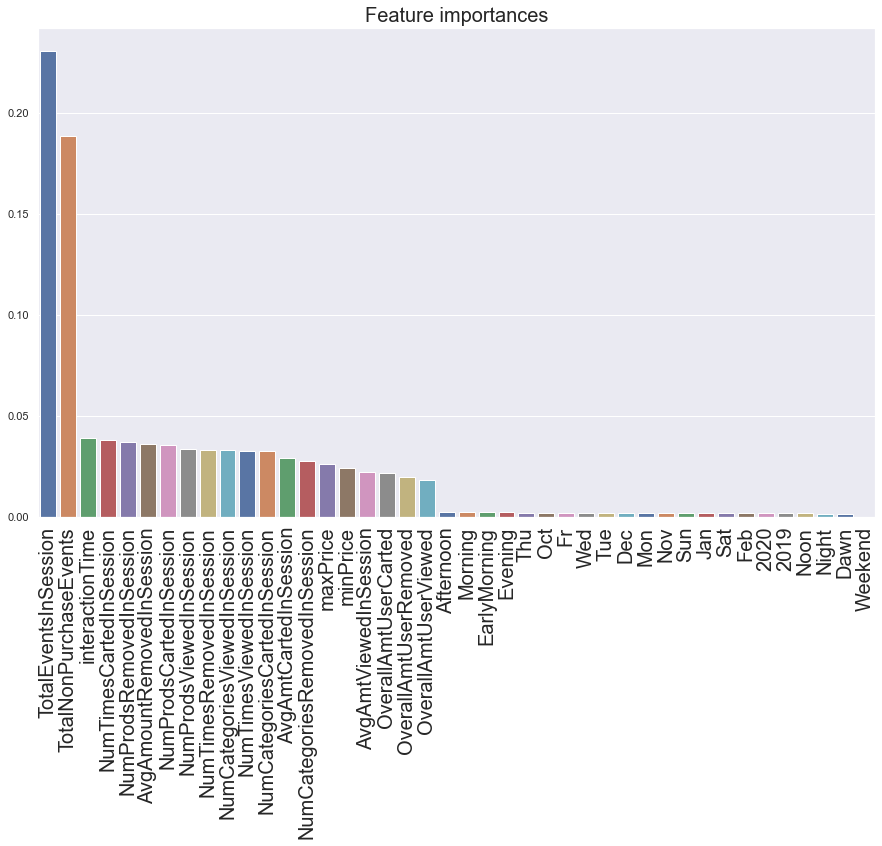

In [273]:
importances = sel.estimator_.feature_importances_
indices = np.argsort(importances)[::-1] 
colname = XData.columns[indices]
plt.figure(figsize=(15,9))
plt.title("Feature importances",size=20)
sns.barplot(x=colname, y=importances[indices],palette="deep")
plt.xticks(rotation=90,size=20)
plt.show()

## 4b. Using F Scores

In [74]:
import sklearn.feature_selection as fs
kb = fs.SelectKBest(k=X_train.shape[1])
kb.fit(X_train, y_train)
names = XData.columns.values[kb.get_support()]
scores = kb.scores_[kb.get_support()]
names_scores = list(zip(names, scores))

In [75]:
fScoreDF = pd.DataFrame(data = names_scores, columns=['Feat_names','F_Scores'])
fScoreDF_sorted = fScoreDF.sort_values(['F_Scores','Feat_names'], ascending =[False, True])

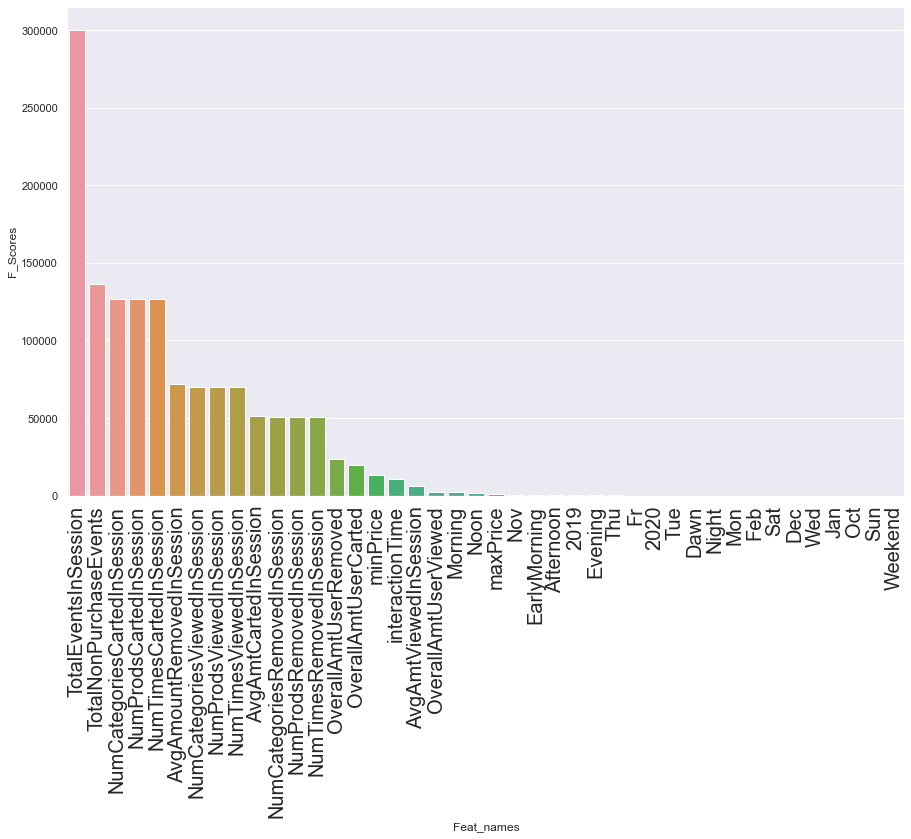

In [275]:
plt.figure(figsize=(15,9))
sns.barplot(x= "Feat_names", y="F_Scores",data=fScoreDF_sorted)
plt.xticks(rotation=90,size=20)
plt.show()

#    
************************************************
************************************************

# 5. ***`TRANSFORMATIONS`***

## 5.1 SMOTE 

In [90]:
print( "Label Distribution Pre Balancing {}".format(Counter(YData)))

Label Distribution Pre Balancing Counter({0: 4380323, 1: 155617})


In [83]:
oversample = SMOTE()
XSMOTE, YSMOTE = oversample.fit_resample(XData, YData)

In [93]:
print( "Label Distribution Post Balancing {}".format( Counter(YSMOTE) ) )

Label Distribution Post Balancing Counter({0: 4380323, 1: 4380323})


In [95]:
trainX, testX, trainY, testY = train_test_split(XSMOTE,YSMOTE,test_size=0.2,random_state=42)

In [96]:
MMscaler = MinMaxScaler()
trainX = MMscaler.fit_transform(trainX)
testX = MMscaler.transform(testX)

**Save/load pickle files for quick future usage**

In [104]:
#FeaturesDFSMOTE = pd.concat([XSMOTE,YSMOTE],axis=1)

#FeaturesDFSMOTE.to_pickle('Cosmetics_Journey_Features_SMOTE.pkl')
# FeaturesDFSMOTE = pd.read_pickle('Cosmetics_Journey_Features_SMOTE.pkl')

## 5.2 PCA

### 5.2.1 Non Balanced Data

**pca1 : Based on the explained variance percentage**

In [22]:
desiredVariancePercent = 0.8

In [23]:
pca1 = PCA()
pca1.fit(X_train)

PCA()

In [24]:
variance_cumsum = np.cumsum(pca1.explained_variance_ratio_)
variance_cumsum

array([0.22658916, 0.30096637, 0.37137599, 0.43967502, 0.5070571 ,
       0.56929571, 0.62861372, 0.67822463, 0.7275744 , 0.77604823,
       0.8231749 , 0.86753635, 0.91019077, 0.94081645, 0.9637546 ,
       0.98499489, 0.99307168, 0.99691496, 0.99779053, 0.99831891,
       0.99875693, 0.99915887, 0.99946415, 0.99959141, 0.99970339,
       0.99979463, 0.99986659, 0.99992593, 0.99996864, 0.9999892 ,
       0.99999678, 0.99999867, 0.99999996, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        ])

In [25]:
numRequiredComponents = next(x[0] for x in enumerate(variance_cumsum.tolist()) if (x[1]> desiredVariancePercent)) + 1
print("Number of components that explain {} percent variance in data are {}".format(desiredVariancePercent*100,numRequiredComponents))

Number of components that explain 80.0 percent variance in data are 11


**pca2 : Number of components defined for variance specified above**

In [26]:
pca2 = PCA(n_components=numRequiredComponents)
pca2.fit(X_train)

PCA(n_components=11)

In [27]:
np.cumsum(pca2.explained_variance_ratio_)

array([0.22658916, 0.30096637, 0.37137599, 0.43967502, 0.5070571 ,
       0.56929571, 0.62861372, 0.67822463, 0.7275744 , 0.77604823,
       0.8231749 ])

**pcaNC2 : Number of components = 2**

In [28]:
pcaNC2 = PCA(n_components=2)
pcaNC2.fit(X_train)

PCA(n_components=2)

**Visualization of Explained Variance Ratio For different components**

In [31]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 43, step=1)
y = np.cumsum(pca1.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='blue')

plt.xlabel('\n Number of Components \n',size = 20)
plt.xticks(np.arange(0, 42, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('\n Cumulative variance (%)\n ',size = 20)
plt.title('The number of components needed to explain variance \n',size = 20)

plt.axhline(y= desiredVariancePercent, color='r', linestyle='-')
plt.axvline(x=numRequiredComponents, color='g', linestyle='--')
plt.text(20, 0.9, '{} cut-off threshold'.format(desiredVariancePercent*100), color = 'red', fontsize=15)

ax.grid(axis='x')
plt.show()

### 5.2.2 Balanced Data

**smote_pca : Number of components NOT defined**

In [219]:
smote_pca = PCA()
smote_pca.fit(trainX)

PCA()

In [224]:
np.cumsum(smote_pca2.explained_variance_ratio_)

array([0.22024005, 0.29377182, 0.36185825, 0.42567654, 0.48586943,
       0.54548691, 0.59974411, 0.65299344, 0.6946747 , 0.73592438,
       0.77647466, 0.81605257, 0.85253943, 0.88716914, 0.91642384,
       0.93544465, 0.95322558, 0.96934481, 0.97767625, 0.9850431 ,
       0.9912788 , 0.99616422, 0.99744915, 0.99825292, 0.99891408,
       0.99934283, 0.99956271, 0.99974534, 0.99988086, 0.99994728,
       0.99998861, 0.99999534, 0.99999967, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        ])

**smote_pca2 : Number of components defined for variance specified**

In [245]:
smote_pca2 = PCA(n_components=12)
smote_pca2.fit(trainX)

PCA(n_components=12)

**smotePcaNC2 : Number of components = 2**

In [ ]:
smote_pcaNC2 = PCA(n_components=2)
smote_pcaNC2.fit(X_train)

**SMOTE PCA Visualization**

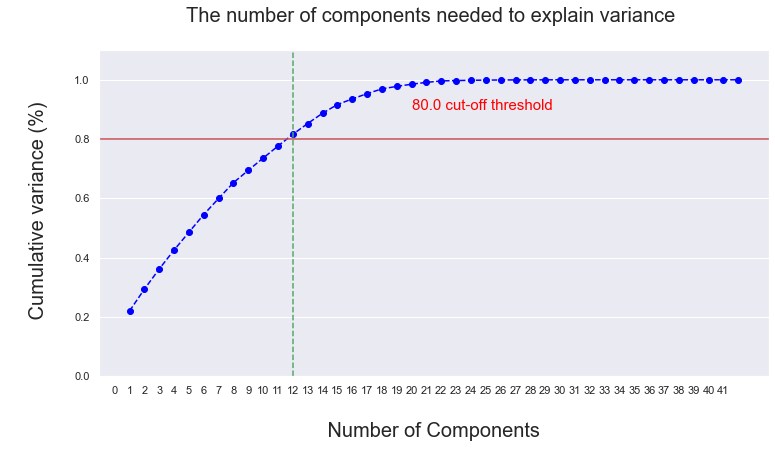

In [277]:
fig, ax = plt.subplots()
xi = np.arange(1, 43, step=1)
y = np.cumsum(smote_pca.explained_variance_ratio_)
NTH_component = next(x[0] for x in enumerate(y.tolist()) if (x[1]> desiredVariancePercent))

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='blue')

plt.xlabel('\n Number of Components \n',size = 20)
plt.xticks(np.arange(0, 42, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('\n Cumulative variance (%)\n ',size = 20)
plt.title('The number of components needed to explain variance \n',size = 20)

plt.axhline(y= desiredVariancePercent, color='r', linestyle='-')
plt.axvline(x=NTH_component+1, color='g', linestyle='--')
plt.text(20, 0.9, '{} cut-off threshold'.format(desiredVariancePercent*100), color = 'red', fontsize=15)

ax.grid(axis='x')
plt.show()

### 5.2.3 PCA Transformations

Non Balanced Data --- 

CHOOSE the function you want to use depending on variance/number of components :

1. pca1
2. pca2
3. pcaNC2

In [250]:
X_train = pca2.transform(X_train)
X_test = pca2.transform(X_test)

In [251]:
X_PCA = np.concatenate([X_train_pca,X_test_pca])

(907188, 11)

In [ ]:
X_PCA.shape

Balanced Data

In [252]:
trainX = smote_pca2.transform(trainX)
testX = smote_pca2.transform(testX)

In [253]:
trainX.shape

(7008516, 12)

#    
************************************************
************************************************

# 6. ***`BASELINING`***

## 6a. BASELINING --- non Balanced data

In [249]:
logreg = LogisticRegression(solver='lbfgs', max_iter=1000,n_jobs=-1)

In [261]:
y_pred = cross_val_predict(logreg, X_train, y_train, cv=5)

In [262]:
print(metrics.accuracy_score(y_train, y_pred))

0.9656565122113608


In [263]:
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=1000, n_jobs=-1)

In [264]:
y_predFinal = logreg.predict(X_test)

In [265]:
print(metrics.accuracy_score(y_test, y_predFinal))

0.9658361883093691


In [266]:
cnf_matrix = metrics.confusion_matrix(y_test, y_predFinal)
cnf_matrix

array([[876195,      0],
       [ 30993,      0]])

Text(0.5, 30.5, 'Predicted label')

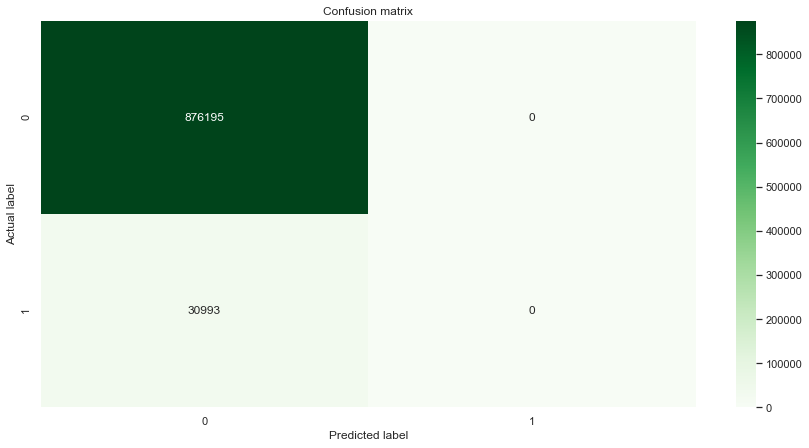

In [278]:
class_names=[1,0] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="Greens" ,fmt='g')
ax.xaxis.set_label_position("bottom")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [280]:
print("Accuracy:",metrics.accuracy_score(y_test, y_predFinal))
print("Precision:",metrics.precision_score(y_test, y_predFinal))
print("Recall:",metrics.recall_score(y_test, y_predFinal))

Accuracy: 0.9658361883093691
Precision: 0.0
Recall: 0.0


## 6b. BASELINING - Balanced data

In [281]:
logreg = LogisticRegression(solver='lbfgs', max_iter=1000,n_jobs=-1)

In [282]:
predY = cross_val_predict(logreg, trainX, trainY, cv=5)

In [283]:
print(metrics.accuracy_score(trainY, predY))

0.9250670184672476


In [284]:
logreg.fit(trainX, trainY)

LogisticRegression(max_iter=1000, n_jobs=-1)

In [285]:
predFinalY = logreg.predict(testX)

In [286]:
print(metrics.accuracy_score(testY, predFinalY))

0.9248052370543282


In [287]:
cnf_matrix_SMOTE = metrics.confusion_matrix(testY, predFinalY)
cnf_matrix_SMOTE

array([[861900,  14896],
       [116855, 758479]])

Text(0.5, 21.5, 'Predicted label SMOTE')

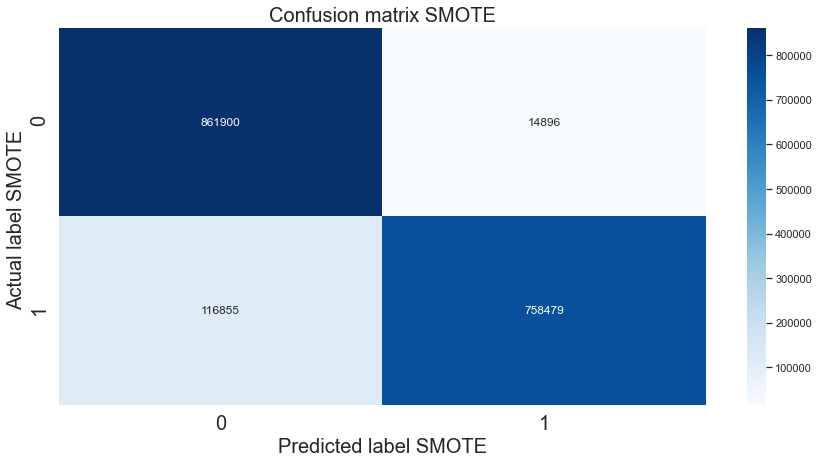

In [288]:
# name  of classes
class_names=[0,1] 
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names,size=20)
plt.yticks(tick_marks, class_names,size=20)

# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix_SMOTE), annot=True, cmap="Blues" ,fmt='g')
ax.xaxis.set_label_position("bottom")
plt.tight_layout()
plt.title('Confusion matrix SMOTE',size = 20)
plt.ylabel('Actual label SMOTE ',size = 20)
plt.xlabel('Predicted label SMOTE',size = 20)

In [289]:
print("Accuracy:",metrics.accuracy_score(testY, predFinalY))
print("Precision:",metrics.precision_score(testY, predFinalY))
print("Recall:",metrics.recall_score(testY, predFinalY))

Accuracy: 0.9248052370543282
Precision: 0.98073896880556
Recall: 0.8665023865176036


#    
************************************************
************************************************

# 7. ***`SUBSETTING DATA/CREATING SAMPLES`***

**NON STRATIFIED**

    FeaturesDF - All Features
    XData, YData - FeaturesDF split into x and y
    X,Y - SMOTE of XData and YData
    XSelect,YSelect- XData with select features
    XSample,YSample - XSelect Sliced upto 'n' rows non stratified

In [ ]:
print(XData.shape)
print(YData.shape)

In [ ]:
# FOR COSMETICS DATA

SelectFeatures = ['TotalEventsInSession', 'interactionTime',
                  'NumTimesCartedinSession','NumTimesRemovedinSession','NumTimesViewedinSession',
                         'maxPrice',    'minPrice',         
            'AvgAmtCartedInSession','AvgAmountRemovedinSession',    'AvgAmtViewedInSession',
       'NumCategoriesViewedinSession', 'NumCategoriesCartedinSession', 'NumCategoriesRemovedinSession',
                  'OverallAmtUserCarted','OverallAmtUserViewed',         'OverallAmtUserRemoved',
             'NumProdsViewedinSession', 'NumProdsCartedInSession',      'NumProdsRemovedinSession']

**Subsets for clustering**

In [ ]:
#Enter the desired subset size

Subset_size = XData.shape[0] # All Rows

# OR

Subset_size = 60000 # Specified number of rows

In [ ]:
#CREATING X SAMPLE

XSelect = XData[SelectFeatures]
XSample = XSelect[:Subset_size].iloc[:,:]

In [ ]:
#Scaling X SAMPLE

MMscaler = MinMaxScaler()
SampleCol = XSample.columns
XSample = MMscaler.fit_transform(XSample)
XSample = pd.DataFrame(XSample,columns=SampleCol)

print(XSample.shape)

In [ ]:
#CREATING Y SAMPLE

YSample = YData[:Subset_size]
print(YSample.value_counts())

#    
************************************************
************************************************

# 8. ***`STRATIFIED SAMPLING`***

XSampleSS - Stratified X Sample

YSampleSS - Stratified Y Sample


## Generating Sample

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=10, test_size = 0.009, random_state=42)


In [ ]:
for train_index, test_index in sss.split(XData, YData):
    XSSS_Train = XData.loc[train_index]
    XSSS_Test = XData.loc[test_index]
    YSSS_Train = YData.loc[train_index]
    YSSS_Test = YData.loc[test_index]


In [ ]:
XSampleSS = XSSS_Test
print(XSampleSS.shape)
YSampleSS = YSSS_Test
print(YSampleSS.shape)

In [ ]:
# FOR COSMETICS DATA

SelectFeatures = ['TotalEventsInSession', 'interactionTime',
                  'NumTimesCartedinSession','NumTimesRemovedinSession','NumTimesViewedinSession',
                         'maxPrice',    'minPrice',         
            'AvgAmtCartedInSession','AvgAmountRemovedinSession',    'AvgAmtViewedInSession',
       'NumCategoriesViewedinSession', 'NumCategoriesCartedinSession', 'NumCategoriesRemovedinSession',
                  'OverallAmtUserCarted','OverallAmtUserViewed',         'OverallAmtUserRemoved',
             'NumProdsViewedinSession', 'NumProdsCartedInSession',      'NumProdsRemovedinSession']

In [ ]:
#Creating Stratified X Sample

XSampleSS = XSampleSS[SelectFeatures]

XSampleSS = XSampleSS.iloc[:,:]
SampleColSS = XSampleSS.columns

XSampleSS = MMscaler.fit_transform(XSampleSS)
XSampleSS = pd.DataFrame(XSampleSS,columns=SampleColSS)

In [ ]:
#Creating Stratified Y Sample
YSampleSS = YSampleSS.Purchase

#    
************************************************
************************************************

# 9. ***`T-SNE`***

## T-SNE FUNCTIONS SETUP

In [ ]:
def generate_tsne(sample_X, sample_Y, perp):
    
    """
    Parameter : Perplexity (5 to 50, increase with density)
    Returns: tsne modified dataframe
    """
    
    tsne = TSNE(n_components=2, perplexity = perp, n_iter = 300, learning_rate=100)
    tsne_results = tsne.fit_transform(sample_X)
    df_tsne = pd.DataFrame(tsne_results, columns=['comp1','comp2'])
    df_tsne['label'] = sample_Y.values
    return df_tsne

In [ ]:
def viz_TSNE(df_tsne):
    
    """
    Parameter :tsne modified dataframe
    Returns: Visualization of tsne
    """
    
    plt.figure(figsize=(9,6))
    sns.lmplot(x='comp1', y='comp2', data = df_tsne, hue='label', fit_reg=False)
    plt.show()

## **TSNE ITERATIONS**

### Trial 1

Using a Stratified Sample

(n_components=2, perplexity = perp, n_iter = 1000, learning_rate=100)

***1.1
Perplexity = 10***

In [ ]:
dfSS10 = generate_tsne(XSampleSS, YSampleSS, 10)

In [ ]:
viz_TSNE(dfSS10)

***1.2
Perplexity = 20***

In [ ]:
dfSS20= generate_tsne(XSampleSS, YSampleSS, 20)

In [ ]:
viz_TSNE(dfSS20)

***1.3
Perplexity = 30***

In [ ]:
dfSS30= generate_tsne(XSampleSS, YSampleSS, 30)

In [ ]:
viz_TSNE(dfSS30)

***1.4
Perplexity = 50***

In [ ]:
dfSS50= generate_tsne(XSampleSS, YSampleSS, 50)

In [ ]:
viz_TSNE(dfSS50)

#    
************************************************
************************************************

# 10. ***`CLUSTERING`***

## DBSCAN FUNCTION

In [32]:
def dbscan(X, eps, min_samples):
    """
    Parameters: 
    X: the X dataframe for clustering
    eps : min distance between points in a cluster
    min_samples: min number of data points in a sample
    
    Returns:
        A DBSCAN visualiazation
        Estimated number of clusters
    """   
    
    X = X.iloc[:,:].values
    db = DBSCAN(eps=eps, min_samples=min_samples)
    db.fit(X)
    y_pred = db.fit_predict(X)
    labels = db.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    plt.scatter(X[:,0], X[:,1],c=y_pred, cmap='Paired')
    plt.title("DBSCAN")
    print('Estimated number of clusters: %d' % n_clusters_)

####  *Finding Optimal Eps value for DBSCAN*

In [ ]:
NN = NearestNeighbors(n_neighbors=100)
nbrs = NN.fit(XSampleSS)

In [ ]:
distances, indices = nbrs.kneighbors(XSampleSS)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.ylim([0,1])
plt.show()

## CLUSTERING after PCA

In [ ]:
# FITTING the stratified sample through PCA
pcaNC2 = PCA(n_components=2)
pcaNC2.fit(XSampleSS)

In [ ]:
# Transforming the stratified sample through PCA
XSampleSS_pca = pcaNC2.transform(XSampleSS)

In [ ]:
#RUNNING DBSCAN WITH EPS = 0.005 AND MIN_SAMPLE = 1000

dbscan(pd.DataFrame(XSampleSS_pca),0.005,1000)

In [ ]:
#RUNNING DBSCAN WITH EPS = 0.005 AND MIN_SAMPLE = 100

dbscan(pd.DataFrame(XSampleSS_pca),0.005,100)

In [ ]:
#RUNNING DBSCAN WITH EPS = 0.03

dbscan(pd.DataFrame(XSampleSS_pca),0.03,1000)

## CLUSTERING after TSNE

In [ ]:
dfX10 = dfSS10.loc[:,:'comp2']
dbscan(dfX10, 0.005, 1000)

In [ ]:
dfX20 = dfSS20.loc[:,:'comp2']
dbscan(dfX20, 0.007, 1000)

In [ ]:
dfX30 = dfSS30.loc[:,:'comp2']
dbscan(dfX30, 0.007, 1000)

## CLUSTERING after PCA + TSNE

**STEP 1 PCA**

In [ ]:
# FITTING the stratified sample through PCA
pcaNC2 = PCA(n_components=2)
pcaNC2.fit(XSampleSS)

In [ ]:
# Transforming the stratified sample through PCA
XSS_pca = pcaNC2.transform(XSampleSS)

**STEP 2 TSNE**

In [ ]:
# Running TSNE with perplexity = 20
df_tsne_pca = generate_tsne(XSS_pca, YSampleSS, 20)

In [ ]:
viz_TSNE(df_tsne_pca)

**STEP 3 Cluster Visualizations**

In [ ]:
#clustering using DBSCAN with eps = 0.03 and min_sample = 1000
dbscan(pd.DataFrame(df_tsne_pca),0.03,1000)

#    
************************************************
************************************************